CLUSTER will be hosted on a remote machine that's connected to all other nodes.

master that manages splitting up the data and the computations. The master is connected to the rest of the computers in the cluster, which are called worker.


Spark's core data structure is the Resilient Distributed Dataset (RDD). This is a low level object that lets Spark work its magic by splitting data across multiple nodes in the cluster. However, RDDs are hard to work with directly, so in this course you'll be using the Spark DataFrame abstraction built on top of RDDs.

In [ ]:
# instalar as dependências
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
# configurar as variáveis de ambiente JAVA e SPARK
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

# tornar o pyspark "importável"
import findspark
findspark.init('spark-2.4.4-bin-hadoop2.7')

To start working with **Spark DataFrames**, you first have to create a SparkSession object from your SparkContext. You can think of the SparkContext as your connection to the cluster and the SparkSession as your interface with that connection.

In [ ]:
######## DATA FRAME ############## 
# https://www.kaggle.com/asrsaiteja/introduction-to-pyspark-using-flightsdata/notebook
# SparkSession called spark available in your workspace!
import warnings
import numpy as np
import pandas as pd
from collections import namedtuple

from pyspark import since
from pyspark.rdd import ignore_unicode_prefix, PythonEvalType
from pyspark.sql.dataframe import DataFrame
from pyspark.sql.udf import UserDefinedFunction
from pyspark.sql.types import IntegerType, StringType, StructType
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

print(spark)

In [ ]:
print(spark.catalog.listTables())

[]


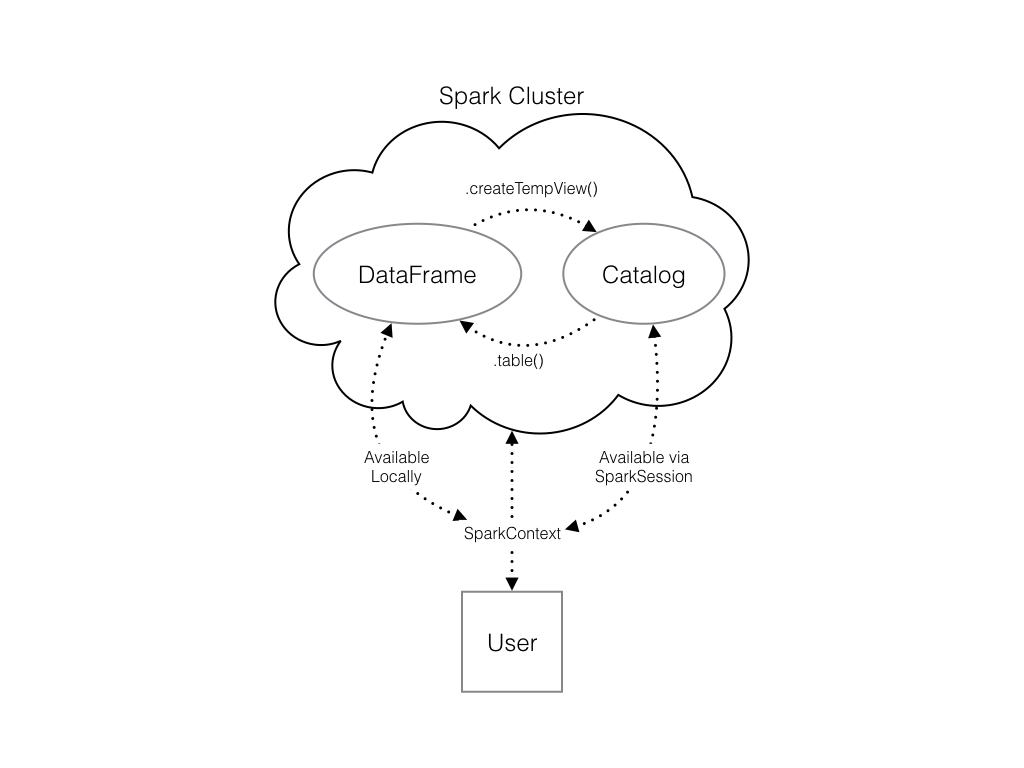

In [ ]:
# DONT RUN
# HOW to put data into Spark via pandas
# Create pd_temp
pd_temp = pd.DataFrame(np.random.random(100))

# Create spark_temp from pd_temp
spark_temp = spark.createDataFrame(pd_temp)

# Examine the tables in the catalog
print(spark.catalog.listTables())

# Add spark_temp to the catalog
spark_temp.createOrReplaceTempView('temp')

# Examine the tables in the catalog again
print(spark.catalog.listTables())

[]
[Table(name='temp', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


### **Import From Sample Data into Files**

In [ ]:
# california_housing_test = spark.read.csv('sample_data/california_housing_test.csv', header = True)
flights = spark.read.csv('flights.csv',header = True)
airports = spark.read.csv('airports.csv',header = True)
airlines = spark.read.csv('airlines.csv',header = True)

# Show the data / Print shows the row
airports.show(10)
# Schema of DATA
flights.printSchema()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Count ROWS
flights.count()
# Count Columns
len(flights.columns)

# adding data into spark view for sql querying
flights.createOrReplaceTempView('flights')
print(spark.catalog.listTables())

[Table(name='flights', database=None, description=None, tableType='TEMPORARY', isTemporary=True), Table(name='temp', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


In [ ]:
### Query ###
# flights.columns
query = '''Select AIRLINE, FLIGHT_NUMBER ,ORIGIN_AIRPORT, DESTINATION_AIRPORT 
                  FROM flights 
                  WHERE ORIGIN_AIRPORT = 'LAX' 
                  LIMIT 10 '''

spark.sql(query).show()

### **DB TO DF** ###

In [ ]:
query = "SELECT ORIGIN_AIRPORT, DESTINATION_AIRPORT, COUNT(*) as N FROM flights GROUP BY ORIGIN_AIRPORT, DESTINATION_AIRPORT"
flight_counts = spark.sql(query)

# Convert the results to a pandas DataFrame
pd_counts = flight_counts.toPandas()
# Print the head of pd_counts
pd_counts.sort_values(by='N',ascending=False).head()

,ORIGIN_AIRPORT,DESTINATION_AIRPORT,N
1343,LAX,JFK,195
2878,JFK,LAX,195
3096,SFO,LAX,171
2089,LAX,SFO,169
2671,LAS,LAX,166


In [ ]:
### Creating Columns ###
'''Updating a Spark DataFrame is somewhat different than working in pandas because the Spark Object is immutable. 
This means that it can't be changed, and so columns can't be updated in place.'''
# df = df.withColumn("newCol", df.oldCol + 1)
flights = flights.withColumn('DURATION_HRS',flights.AIR_TIME/60.)


In [ ]:
# SELECT SOME COLUMNS
flights.select('AIR_TIME','DURATION_HRS').show(10)

+--------+------------------+
|AIR_TIME|      DURATION_HRS|
+--------+------------------+
|     169| 2.816666666666667|
|     263| 4.383333333333334|
|     266| 4.433333333333334|
|     258|               4.3|
|     199| 3.316666666666667|
|     206| 3.433333333333333|
|     154| 2.566666666666667|
|     228|               3.8|
|     173|2.8833333333333333|
|     186|               3.1|
+--------+------------------+
only showing top 10 rows



### **Filter Spark** ### 
Filter Spark == Where SQL, filter is a alias for where, both works

In [ ]:
temp = flights.select('ORIGIN_AIRPORT','AIR_TIME').filter('AIR_TIME > 200')  # OR (flights.air_time > 200) [BOOLEAN]
temp.show(10)
# == SELECT ORIGIN_AIRPORT,AIR_TIME FROM flights WHERE air_time > 200

In [ ]:
# Two filters - First A , then B
filterA = temp.ORIGIN_AIRPORT == 'LAX'
filterB = temp.AIR_TIME > 200

sel2 = temp.where(filterA).filter(filterB)
sel2.show(10)

### **Selecting II** ###

In [ ]:
#selecExpr is able to put expression
sel3 = flights.selectExpr('ORIGIN_AIRPORT','AIR_TIME',"AIR_TIME/60 as duration_hrs")
# sel3.show(10)

#select is able to call a column or variable
duration_hrs = (flights.AIR_TIME/60).alias('duration_hrs')
sel4 = flights.select('ORIGIN_AIRPORT','AIR_TIME',duration_hrs)
sel4.show(10)

### **Data Types** ###

In [ ]:
from pyspark.sql.functions import col, round

sel4 = sel4.withColumn("duration_hrs", round(sel4.duration_hrs,2))
sel4 = sel4.withColumn("AIR_TIME",sel4.AIR_TIME.cast("integer"))
sel4.show(10)

In [ ]:
sel4.printSchema()

### **GROUP BY** ###

In [ ]:
# Find the shortest flight from PDX in terms of distance
flights.filter(flights.origin == 'PDX').groupBy().min('distance').show()

# Find the longest flight from SEA in terms of air time
flights.filter(flights.origin == 'SEA').groupBy().max('air_time').show()

In [ ]:
# Average duration of Delta flights
flights = flights.withColumn("AIR_TIME",flights.AIR_TIME.cast("int"))
flights.filter(flights.AIRLINE == "DL").filter(flights.ORIGIN_AIRPORT == "SEA").groupBy().avg("AIR_TIME").show()

# Total hours in the air
# withColumn - Return ALL DF with Columns Added - CASE SENSITIVE
flights.withColumn("AIR_TIME", flights.AIR_TIME/60).groupBy().sum("AIR_TIME").show()

flights.withColumn("duration_hrs", flights.air_time/60).groupBy().sum("duration_hrs").show()

In [ ]:
flights.columns

In [ ]:
flights = flights.withColumn('DEPARTURE_DELAY',flights.DEPARTURE_DELAY.cast('double'))
flights.show(10)

In [ ]:
# .agg() Method - This method lets you pass an aggregate column expression that uses any 
#  of the aggregate functions from the pyspark.sql.functions submodule.

import pyspark.sql.functions as F

by_month_dest = flights.groupBy('MONTH','DESTINATION_AIRPORT')
by_month_dest.avg('DEPARTURE_DELAY').show(5)

# Standard deviation of departure delay
by_month_dest.agg(F.stddev('DEPARTURE_DELAY')).show(5)

### **Joining** ###


In [ ]:
#df.join(df2, df.name == df2.name, 'outer').select(df.name, df2.height).sort("name", descending = True).collect()
#EX : [Row(name='Bob', height=85), Row(name='Alice', height=None), Row(name=None, height=80)]

airports = airports.withColumnRenamed('IATA_CODE','COD')
airports.show(5)

+---+--------------------+-----------+-----+-------+--------+----------+
|COD|             AIRPORT|       CITY|STATE|COUNTRY|LATITUDE| LONGITUDE|
+---+--------------------+-----------+-----+-------+--------+----------+
|ABE|Lehigh Valley Int...|  Allentown|   PA|    USA|40.65236| -75.44040|
|ABI|Abilene Regional ...|    Abilene|   TX|    USA|32.41132| -99.68190|
|ABQ|Albuquerque Inter...|Albuquerque|   NM|    USA|35.04022|-106.60919|
|ABR|Aberdeen Regional...|   Aberdeen|   SD|    USA|45.44906| -98.42183|
|ABY|Southwest Georgia...|     Albany|   GA|    USA|31.53552| -84.19447|
+---+--------------------+-----------+-----+-------+--------+----------+
only showing top 5 rows



In [ ]:
flights_with_airports = flights.join(airports, flights.ORIGIN_AIRPORT == airports.COD , how = "inner").select(
    flights.ORIGIN_AIRPORT,airports.CITY).sort("ORIGIN_AIRPORT",ascending=True).distinct()
flights_with_airports.show(10)

+--------------+-------------+
|ORIGIN_AIRPORT|         CITY|
+--------------+-------------+
|           ABE|    Allentown|
|           ABI|      Abilene|
|           ABQ|  Albuquerque|
|           ABR|     Aberdeen|
|           ABY|       Albany|
|           ACT|         Waco|
|           ACV|Arcata/Eureka|
|           ACY|Atlantic City|
|           ADK|         Adak|
|           ADQ|       Kodiak|
+--------------+-------------+
only showing top 10 rows



### **Machine Learning Pipelines**

Next > Every stage of the machine learning pipeline, from data intake to model evaluation.
At the core of the `pyspark.ml` module are the `Transformer and Estimator` classes. Almost every other class in the module behaves similarly to these two basic classes.

`Transformer` classes have a `.transform()` method that takes a DataFrame and returns a new DataFrame; usually the original one with a new column appended. For example, you might use the class `Bucketizer` to create discrete bins from a continuous feature or the class `PCA` to reduce the dimensionality of your dataset using principal component analysis.

`Estimator` classes all implement a `.fit()` method. These methods also take a DataFrame, but instead of returning another DataFrame they return a model object. This can be something like a `StringIndexerModel` for including categorical data saved as strings in your models, or a `RandomForestModel` that uses the random forest algorithm for classification or regression.

- Working in Spark allows you to create reproducible machine learning pipelines.

- Machine learning pipelines in Spark are made up of Transformers and Estimators.

- PySpark uses the pyspark.ml submodule to interface with Spark's machine learning routines.

To build a model that predicts whether or not a flight will be delayed based on the flights data.


---


In [ ]:
planes = spark.read.csv('planes.csv',sep=';',header=True)
# Rename year column
planes = planes.withColumnRenamed('year','plane_year')
planes = planes.withColumnRenamed('tailnum','TAIL_NUMBER')

planes.show(10)

+-----------+----------+--------------------+--------------------+--------------+-------+-----+-----+-------------+
|TAIL_NUMBER|plane_year|                type|        manufacturer|         model|engines|seats|speed|       engine|
+-----------+----------+--------------------+--------------------+--------------+-------+-----+-----+-------------+
|     N38451|      1998|Fixed wing multi ...|    AIRBUS INDUSTRIE|      A320-214|      2|  182|   NA|    Turbo-fan|
|     N567AA|      1999|Fixed wing multi ...|    AIRBUS INDUSTRIE|      A320-214|      2|  182|   NA|    Turbo-fan|
|     N623NK|      1999|Fixed wing multi ...|    AIRBUS INDUSTRIE|      A320-214|      2|  182|   NA|    Turbo-fan|
|     N442AS|      1999|Fixed wing multi ...|    AIRBUS INDUSTRIE|      A320-214|      2|  182|   NA|    Turbo-fan|
|     N902DE|      1999|Fixed wing multi ...|    AIRBUS INDUSTRIE|      A320-214|      2|  182|   NA|    Turbo-fan|
|     N4YUAA|      1999|Fixed wing multi ...|    AIRBUS INDUSTRIE|      

In [ ]:
# Build a Boolean column
# model_data has information about the airplanes and flights

# In the next two chapters you'll be working to build a model that predicts whether or not a flight will be delayed 
# based on the flights data we've been working with.

# Join the DataFrames
model_data = flights.join(planes,on="TAIL_NUMBER", how="leftouter")
model_data = model_data.withColumn("plane_age", (2021 - model_data.plane_year))

In [ ]:
model_data.show(10)

+-----------+----+-----+---+-----------+-------+-------------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+----------+--------------------+--------------------+--------------+-------+-----+-----+-------------+---------+-------+-----+
|TAIL_NUMBER|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|plane_year|                type|        manufacturer|         model|engines|seats

In [ ]:
#DF FINAL DO DATACAMP
|tailnum|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|flight|origin|dest|air_time|distance|hour|minute|plane_year|plane_age|is_late|label|dest_index|      dest_fact|carrier_index|  carrier_fact|            features|
+-------+----+-----+---+--------+---------+--------+---------+-------+------+------+----+--------+--------+----+------+----------+---------+-------+-----+----------+---------------+-------------+--------------+--------------------+
| N102UW|2014|    1| 12|     831|       -4|    1618|      -21|     US|  1883|   SEA| PHL|     265|    2378|   8|    31|      1998|     16.0|  false|    0|      30.0|(70,[30],[1.0])|          5.0|(10,[5],[1.0])|(83,[0,1,32,77,82...|


In [ ]:
model_data.columns

It's important to know that Spark **only handles numeric data**. That means all of the columns in your DataFrame must be either integers or decimals (called 'doubles' in Spark).!!

In [ ]:
# Cast the columns to integers
model_data = model_data.withColumn("ARRIVAL_DELAY", model_data.ARRIVAL_DELAY.cast('integer'))
model_data = model_data.withColumn("AIR_TIME", model_data.AIR_TIME.cast('integer'))
model_data = model_data.withColumn("MONTH", model_data.MONTH.cast('integer'))
model_data = model_data.withColumn("plane_age", model_data.plane_age.cast('integer'))

In [ ]:
# Create is_late
model_data = model_data.withColumn("is_late", model_data.ARRIVAL_DELAY > 0)

# Convert to an integer
model_data = model_data.withColumn("label", model_data.is_late.cast('integer'))

# Remove missing values
model_data = model_data.filter("ARRIVAL_DELAY is not NULL and DEPARTURE_DELAY is not NULL and AIR_TIME is not NULL and plane_year is not NULL")


**One-hot vectors** - Function to handle with non-numerical (categorical)  features, as airlines and destinations.

**One-hot vector** is a way of representing a categorical feature where every observation has a vector in which all elements are zero except for at most one element, which has a value of one (1).

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder


### Carrier ###
'''In this exercise you'll create a StringIndexer and a OneHotEncoder to code the carrier
To do this, you'll call the class constructors with the arguments inputCol and outputCol.
The inputCol is the name of the column you want to index or encode, and the outputCol 
is the name of the new column that the Transformer should create.'''

carr_indexer = StringIndexer(inputCol="AIRLINE",outputCol="carrier_index")
# Create a OneHotEncoder
carr_encoder = OneHotEncoder(inputCol="carrier_index",outputCol="carrier_fact")
carr_encoder

OneHotEncoder_7682036006c6

In [ ]:
### DESTINATION ###
# Create a StringIndexer
dest_indexer = StringIndexer(inputCol="DESTINATION_AIRPORT",outputCol="dest_index")

# Create a OneHotEncoder
dest_encoder = OneHotEncoder(inputCol="dest_index",outputCol="dest_fact")

The last step in the **Pipeline** is to combine all of the columns containing our features into a single column. This has to be done before modeling can take place because every Spark modeling routine expects the data to be in this form. 

In [ ]:
from pyspark.ml.feature import VectorAssembler

name = ["MONTH", "AIR_TIME", "carrier_fact", "dest_fact", "plane_age"]
vec_assembler = VectorAssembler(inputCols= name, outputCol="features")

#### PIPELINE ####
Combines all the Estimators and Transformers that you've already created. This lets you reuse the same modeling process over and over again by wrapping it up in one simple object. Neat, right?

In [ ]:
# Import Pipeline
from pyspark.ml import Pipeline

# Make the pipeline
# Stages should be a list holding all the stages you want your data to go through in the pipeline. Here this is just:

stage = [dest_indexer, dest_encoder, carr_indexer, carr_encoder, vec_assembler]
flights_pipe = Pipeline(stages=stage)

In [ ]:
# Fit and transform the data
piped_data = flights_pipe.fit(model_data).transform(model_data)
piped_data.show(5)

In [ ]:
# Split the data into training and test sets
training, test = piped_data.randomSplit([.6, .4])
training.count()

In [ ]:
### TRAINING ###
|tailnum|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|flight|origin|dest|air_time|distance|hour|minute|plane_year|plane_age|is_late|label|dest_index|      dest_fact|carrier_index|  carrier_fact|            features|
+-------+----+-----+---+--------+---------+--------+---------+-------+------+------+----+--------+--------+----+------+----------+---------+-------+-----+----------+---------------+-------------+--------------+--------------------+
| N102UW|2014|    1| 12|     831|       -4|    1618|      -21|     US|  1883|   SEA| PHL|     265|    2378|   8|    31|      1998|     16.0|  false|    0|      30.0|(70,[30],[1.0])|          5.0|(10,[5],[1.0])|(83,[0,1,32,77,82...|
| N102UW|2014|    2| 25|    1315|       -5|    2103|       -7|     US|  1805|   SEA| CLT|     256|    2279|  13|    15|      1998|     16.0|  false|    0|      34.0|(70,[34],[1.0])|          5.0|(10,[5],[1.0])|(83,[0,1,36,77,82...|
| N102UW|2014|    2|  3|     832|       -3|    1709|       30|     US|  1935|   SEA| PHL|     274|    2378|   8|    32|      1998|     16.0|   true|    1|      30.0|(70,[30],[1.0])|          5.0|(10,[5],[1.0])|(83,[0,1,32,77,82...|

In [ ]:
### TEST ###
+-------+----+-----+---+--------+---------+--------+---------+-------+------+------+----+--------+--------+----+------+----------+---------+-------+-----+----------+---------------+-------------+--------------+--------------------+
|tailnum|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|flight|origin|dest|air_time|distance|hour|minute|plane_year|plane_age|is_late|label|dest_index|      dest_fact|carrier_index|  carrier_fact|            features|
+-------+----+-----+---+--------+---------+--------+---------+-------+------+------+----+--------+--------+----+------+----------+---------+-------+-----+----------+---------------+-------------+--------------+--------------------+
| N102UW|2014|    5| 15|    1322|       17|    2113|        0|     US|  1971|   SEA| CLT|     268|    2279|  13|    22|      1998|     16.0|  false|    0|      34.0|(70,[34],[1.0])|          5.0|(10,[5],[1.0])|(83,[0,1,36,77,82...|
| N102UW|2014|    5| 16|    1256|       -9|    2026|      -47|     US|  1971|   SEA| CLT|     247|    2279|  12|    56|      1998|     16.0|  false|    0|      34.0|(70,[34],[1.0])|          5.0|(10,[5],[1.0])|(83,[0,1,36,77,82...|
| N102UW|2014|    5|  7|    1311|        6|    2115|        2|     US|  1971|   SEA| CLT|     274|    2279|  13|    11|      1998|     16.0|   true|    1|      34.0|(70,[34],[1.0])|          5.0|(10,[5],[1.0])|(83,[0,1,36,77,82...|

In [ ]:
test.show(10)

**LOGISTIC REGRESSION**

The model you'll be fitting in this chapter is called a logistic regression. This model is very similar to a linear regression, but instead of predicting a numeric variable, it predicts the probability (between 0 and 1) of an event.

To use this as a classification algorithm, all you have to do is assign a `cutoff` point to these probabilities. If the predicted probability is above the cutoff point, you classify that observation as a 'yes' (in this case, the flight being late), if it's below, you classify it as a 'no'!

You'll tune this model by testing different values for several hyperparameters. A `hyperparameter` is just a value in the model that's not estimated from the data, but rather is supplied by the **user to maximize performance**. For this course it's not necessary to understand the mathematics behind all of these values - what's important is that you'll try out a few different choices and pick the best one.

In [ ]:
# Import LogisticRegression
from pyspark.ml.classification import LogisticRegression

# Create a LogisticRegression Estimator
lr = LogisticRegression()

**Cross validation**

In the next few exercises you'll be tuning your logistic regression model using a procedure called k-fold cross validation. This is a method of estimating the model's performance on unseen data (like your test DataFrame).

It works by splitting the training data into a few different partitions. The exact number is up to you, but in this course you'll be using PySpark's default value of three. Once the data is split up, one of the partitions is set aside, and the model is fit to the others. Then the error is measured against the held out partition. This is repeated for each of the partitions, so that every block of data is held out and used as a test set exactly once. Then the error on each of the partitions is averaged. This is called the cross validation error of the model, and is a good estimate of the actual error on the held out data.

**GRID SEARCH**

Search in a grid with validation cross:

> model = DecisionTreeClassifier(random_state=123) \
> GridSearchCV (model,params,cv = 10,scoring = 'roc-auc') \
  cv - divide the dataset in 10 parts, 9 for training , 1 for test.\

Grid-search is used to find the optimal hyperparameters of a model which results in the most ‘accurate’ predictions.
We force the GRID to test all the parameters until we figure out the best one.
 
> class_weight - When we have some feature unbalanced, much more than other.




In [ ]:
import pyspark.ml.evaluation as evals 

evaluator = evals.BinaryClassificationEvaluator(metricName="areaUnderROC")

Next, you need to create a grid of values to search over when looking for the optimal hyperparameters. The submodule pyspark.ml.tuning includes a class called ParamGridBuilder that does just that (maybe you're starting to notice a pattern here; **PySpark has a submodule for just about everything!**).

You'll need to use the .addGrid() and .build() methods to create a grid that you can use for cross validation. The .addGrid() method takes a model parameter (an attribute of the model Estimator, lr, that you created a few exercises ago) and a list of values that you want to try. The .build() method takes no arguments, it just returns the grid that you'll use later.

In [ ]:
# Import the tuning submodule
import pyspark.ml.tuning as tune

# Create the parameter grid
grid = tune.ParamGridBuilder()

# Add the hyperparameter
grid = grid.addGrid(lr.regParam, np.arange(0, .1, .01))
grid = grid.addGrid(lr.elasticNetParam, [0, 1])

# Build the grid
grid = grid.build()

In [ ]:
grid

In [ ]:
# Create the CrossValidator
cv = tune.CrossValidator(estimator=lr,
               estimatorParamMaps=grid,
               evaluator=evaluator
               )

Output below:

LogisticRegressionModel: uid=LogisticRegression_72515582991a, numClasses=2, numFeatures=83;

Remember the best AUC is 1.
ROC is the curve.

In [ ]:
# Call lr.fit()
best_lr = lr.fit(training)

# Print best_lr
print(best_lr)

In [ ]:
#It's finally time to test your model on it! You can use the same evaluator you made to fit the model.
# Use the model to predict the test set
test_results = best_lr.transform(tes)

# Evaluate the predictions
print(evaluator.evaluate(test_results))
# 0.7123313100891033